# Yelp Review's Sentiment Analysis

In [3]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.stem import *
from stop_words import get_stop_words
import string

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn_evaluation import plot
%matplotlib inline 

from pprint import pprint
from time import time
import logging

In [5]:
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

Automatically created module for IPython interactive environment


In [16]:
business=(pd.read_csv(r"C:\Users\sdahiya\Documents\Projects\Yelp\yelp_business.csv",encoding='latin-1')
            .rename(columns={'stars': 'business_stars'})) 

reviews=(pd.read_csv(r"C:\Users\sdahiya\Documents\Projects\Yelp\yelp_reviews.csv",parse_dates=["date"])
         .rename(columns={'stars': 'review_stars'})) 

In [17]:
business.sample(n=5)

,business_id,city,state,neighborhoods,business_stars,review_count,categories
64451,CECYpgLeL0Vd02mpICiZ2g,Karlsruhe,BW,[],4.0,5,"['Pubs', 'Bars', 'Nightlife']"
41219,0zcHBms7sK9IYv4zn_qrqQ,Queen Creek,AZ,[],4.0,38,"['Fast Food', 'Restaurants']"
32814,3Fd6CaUA8Z355BA9eDLaRg,Edinburgh,EDH,"['Grassmarket', 'Old Town']",4.0,3,"[""Women's Clothing"", ""Men's Clothing"", 'Fashio..."
63573,muSVaKBpQN_t61AYwg5WLA,Phoenix,AZ,[],5.0,28,"['Tattoo', 'Piercing', 'Beauty & Spas']"
57564,Oo02F1-xfy8wEyMICSvsPw,Phoenix,AZ,[],4.5,7,"['Barbers', 'Beauty & Spas']"


In [18]:
reviews.sample(n=5)

,user_id,business_id,date,review_stars,text,votes
1225642,YIW_CX0vR_zVwdg3KE12xg,EUmfOpiQxJ5yaEMypI30gQ,2013-08-17,5,"b""we eat mexican food all the time. when we tr...","{'cool': 0, 'funny': 0, 'useful': 0}"
155293,lNy8SwuAyq4O2oosW-uGUQ,nzJxNn-tKG7kw_zf7xaYbg,2014-04-05,2,"b""let's start with what i liked: the view, and...","{'cool': 0, 'funny': 0, 'useful': 2}"
1410077,D61_mJH0pPh-grBjZyGn1g,7jZPyx3CrnLn8l8V08fsCw,2015-05-22,5,"b""ron was fantastic! fast quick and price adve...","{'cool': 0, 'funny': 0, 'useful': 0}"
641502,GSfT1Rogrq7K5NuQ3QKSRA,ILoDsxtqtLU2oTMaf_laGQ,2015-10-01,5,b'went in for my usual gyro with feta and frie...,"{'cool': 1, 'funny': 0, 'useful': 1}"
1150277,flW7sm9KfoBhyE2okAL3eQ,Xhg93cMdemu5pAMkDoEdtQ,2010-09-08,2,"b""honestly, i was very disappointed when i cam...","{'cool': 0, 'funny': 0, 'useful': 1}"


In [19]:
business = business.assign(rest_flag=lambda x : x.categories.apply(lambda l: 1 if 'Restaurants' in  l else 0))
business = business.loc[business.rest_flag == 1, :].reset_index(drop=True)

In [20]:
business.sample(n=5)

,business_id,city,state,neighborhoods,business_stars,review_count,categories,rest_flag
11128,GS9BIDELUnYgAKznlpUirA,Las Vegas,NV,['Westside'],4.5,37,"['Sushi Bars', 'Restaurants']",1
1068,O02yhnk20alGOBw0HcmHGw,Phoenix,AZ,[],3.0,3,"['Burgers', 'Fast Food', 'Restaurants']",1
10690,vJa7fLf60RuA6EAVXcXpnQ,Edinburgh,EDH,['New Town'],4.0,28,"['Food', 'Arts & Entertainment', 'Wineries', '...",1
9181,MS2jb5dWW1DR_JIYziPV_w,Montéal,QC,['Ville-Marie'],3.0,8,"['Wine Bars', 'Bars', 'Nightlife', 'Canadian (...",1
24930,1mgQIFFGeUc15_xk2mQDrw,Laval,QC,[],2.5,3,"['Food', 'Coffee & Tea', 'Breakfast & Brunch',...",1


In [26]:
yelp = pd.merge(business.loc[:,("business_id","rest_flag","city",)],\
                reviews.loc[:,("business_id","user_id","review_stars","text")],on = "business_id", how = "left")

In [41]:
yelp.sample(n=5)

,business_id,rest_flag,city,user_id,review_stars,text,length
303401,bmNPNlCLDplWB55ic3Bixg,1,Las Vegas,VgifuUjzF99wtv84rAhYJQ,5.0,amazing japanese food expensive but worth ...,21
876385,tpJjVxyor9OOQfYgvAtdRA,1,Mesa,WBZXNbaf1hmID5VgGAIX0g,4.0,hue is a very fun place to stop in for a casu...,285
1013372,bOB11LVavtN9PWTNwR52Tw,1,Scottsdale,U-Ym1nXJbgtrgOQAGG16AA,3.0,my husband and i were in scottsdale for the w...,94
237383,88CNSyeoKhGn1x0SHvz8Ig,1,Las Vegas,3k60ftRA27mKgYSTiamy7A,2.0,if you re looking for a quiet place to have d...,240
492887,0K8roYiVL3c5koa5pDEBUw,1,Charlotte,6f9xCzChuA5eBoxoR6EmAQ,2.0,i ve always been a fan of bricktops however t...,118


In [28]:
yelp.review_stars.value_counts()

5.0    496010
4.0    408087
3.0    196084
1.0    132420
2.0    130641
Name: review_stars, dtype: int64

In [29]:
def text_length(x):
    try:
        return len(x.split())
    except:
        return 0

In [35]:
yelp.loc[:,"length"] = yelp.text.apply(lambda x: text_length(x))
yelp = yelp.loc[yelp.length>0,:]
yelp.loc[:,"text"] = yelp.text.apply(lambda x: x[1:])

In [36]:
exclude = set(string.punctuation)

def remove_punctuation(s):
    '''For removing punctuation
    '''
    s = ''.join(ch if ch not in exclude else " " for ch in s )
    return s.lower()

yelp.loc[:,"text"] = yelp.text.apply(lambda x: remove_punctuation(x))

In [44]:
stop_words = get_stop_words('en')

def remove_stopWords(s):
    '''For removing stop words
    '''
    s = ' '.join(word for word in s.split() if word not in stop_words)
    return s

yelp.loc[:,"text"] = yelp.text.apply(lambda x: remove_stopWords(x))

In [18]:
def remove_Number(s):
    '''For filtering the numbers
    '''
    s = ''.join(ch for ch in s if not ch.isdigit())
    return s

yelp.loc[:,"text"] = yelp.text.apply(lambda x: remove_Number(x))

In [21]:
wnl = WordNetLemmatizer()

def lemmatize(s):
    '''For lemmatizing the word
    '''
    s = ' '.join(wnl.lemmatize(word) for word in s.split())
    return s

yelp.loc[:,"text"] = yelp.text.apply(lambda x: lemmatize(x))

In [22]:
def remove_words_len(s,l):
    '''for filtering out words of length l
    '''
    s = ' '.join(word for word in s.split() if len(word)>l)
    return s.lower()

yelp.loc[:,"text"] = yelp.text.apply(lambda x: remove_words_len(x,1))

In [7]:
samp2_1 = yelp.loc[yelp.review_stars.isin([1.0,2.0]),:]
samp30 = yelp.loc[yelp.review_stars == 3.0,:].sample(axis=0,n=132420,random_state=1)
samp41 = yelp.loc[yelp.review_stars == 4.0,:].sample(axis=0,n=132420,random_state=1)
samp42 = yelp.loc[yelp.review_stars == 4.0,:].sample(axis=0,n=132420,random_state=2)
samp51 = yelp.loc[yelp.review_stars == 5.0,:].sample(axis=0,n=132420,random_state=1)
samp52 = yelp.loc[yelp.review_stars == 5.0,:].sample(axis=0,n=132420,random_state=2)

In [8]:
data1 = pd.concat([samp2_1,samp30,samp41,samp51],ignore_index=True)
data2 = pd.concat([samp2_1,samp30,samp42,samp52],ignore_index=True)
data3 = pd.concat([samp2_1,samp30,samp41,samp52],ignore_index=True)
data4 = pd.concat([samp2_1,samp30,samp42,samp51],ignore_index=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data4.text, data4.review_stars, \
                                                                       test_size=0.33, random_state=42)

In [10]:
vectorizer = TfidfVectorizer(smooth_idf=False,
                             #tokenizer=LemmaTokenizer(),
                             min_df = 1000,
                             #max_df = .9999
                             ngram_range = (1,2)
                              #,stop_words = 'english'
                             )


In [16]:
X_train_hv = vectorizer.fit_transform(X_train)
X_test_hv = vectorizer.transform(X_test)

In [18]:
def gridSearch(pipeline,parameters,CV=3,score=None,jobs=-2):
    if __name__ == "__main__":
        # multiprocessing requires the fork to happen in a __main__ protected
        # block

        # find the best parameters for both the feature extraction and the
        # classifier
        grid_search = GridSearchCV(pipeline, parameters, n_jobs=jobs, verbose=1,cv=CV,scoring=score)

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipeline.steps])
        print("parameters:")
        pprint(parameters)
        t0 = time()
        grid_search.fit(X_train_hv,  y_train)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best score: %0.3f" % grid_search.best_score_)
        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))
        return grid_search

In [19]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [20]:
pipeline_pac= Pipeline([
         ('pac',PassiveAggressiveClassifier())
])


parameters_pac = { 'pac__C': (0.1,1,10)
    
}

In [21]:
pac_grid = gridSearch(pipeline_pac,parameters_pac,CV=10,score='f1_macro')

Performing grid search...
pipeline: ['pac']
parameters:
{'pac__C': (0.1, 1, 10)}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished


done in 101.117s

Best score: 0.559
Best parameters set:
	pac__C: 0.1


In [46]:
import operator
def vis_df(grid):    
    df = pd.DataFrame(grid.cv_results_)
    idVars = df.filter(regex=("param_*")).drop("params",axis=1).columns.values
    valueVars = df.filter(regex=("split*")).columns.values
    df = pd.melt(df, id_vars=idVars,value_vars=list(valueVars))
    df.loc[:,("split")] = df.variable.apply(lambda x: x.split('_')[0])
    df.loc[:,("validation")] = df.variable.apply(lambda x: x.split('_')[1])
    for col in df.filter(regex="param*").columns:
        df.loc[:,col] = df.loc[:,col].apply(lambda x: str(sorted(x.items(), key=operator.itemgetter(0))) \
                                            if type(x) is dict else str(x)  )
    return df.drop("variable",axis=1).rename(columns={'value':'score'})

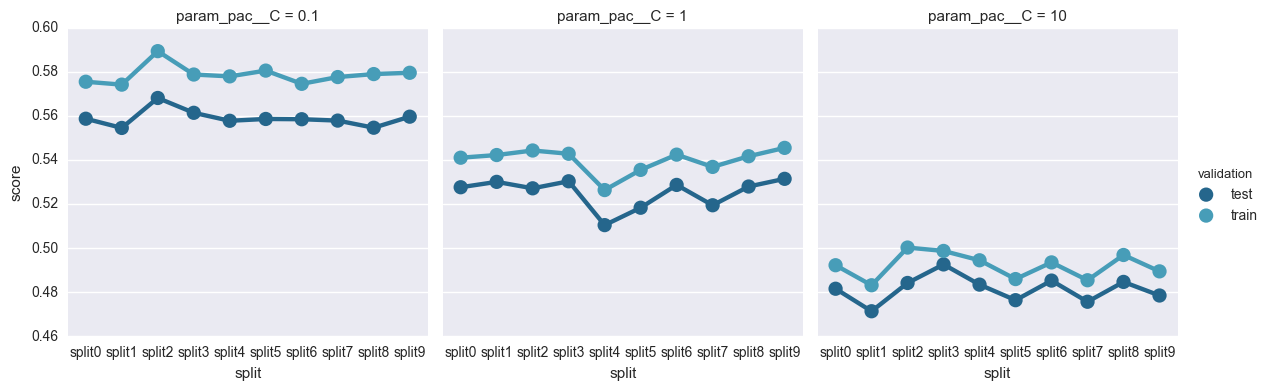

In [47]:
g = sns.factorplot(x="split", y="score",hue = "validation" ,col="param_pac__C",  data=vis_df(pac_grid),
                   capsize=.2, palette="YlGnBu_d", size=4, aspect=1)
g.despine(left=True)

In [31]:
pipeline_svd = Pipeline([
         ('svd',SGDClassifier(warm_start = True))
])

parameters_svd = {'svd__penalty': ('l2', 'l1'),
                  'svd__loss': ('hinge','log')
    
}

In [32]:
svd_grid = gridSearch(pipeline_svd,parameters_svd,CV=10,score='f1_macro')

Performing grid search...
pipeline: ['svd']
parameters:
{'svd__loss': ('hinge', 'log'), 'svd__penalty': ('l2', 'l1')}
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:  2.4min finished


done in 153.266s

Best score: 0.575
Best parameters set:
	svd__loss: 'log'
	svd__penalty: 'l2'


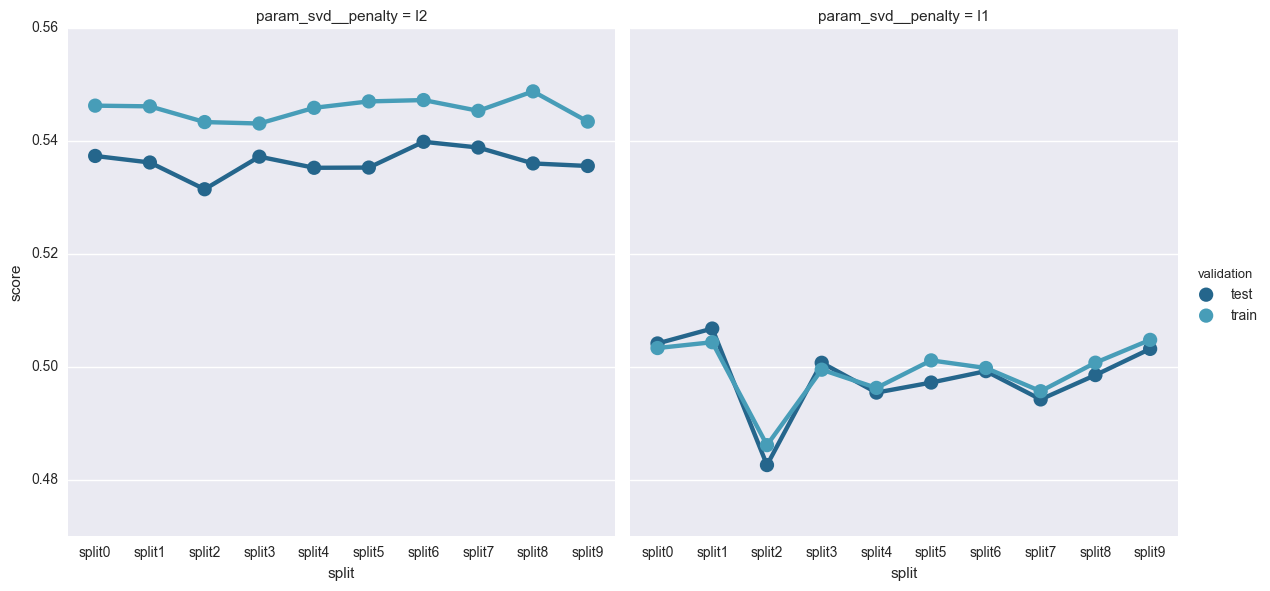

In [48]:
g = sns.factorplot(x="split", y="score", hue="validation",col="param_svd__penalty", data=vis_df(svd_grid),
                   capsize=.2, palette="YlGnBu_d", size=6, aspect=1,ci=None)
g.despine(left=True)

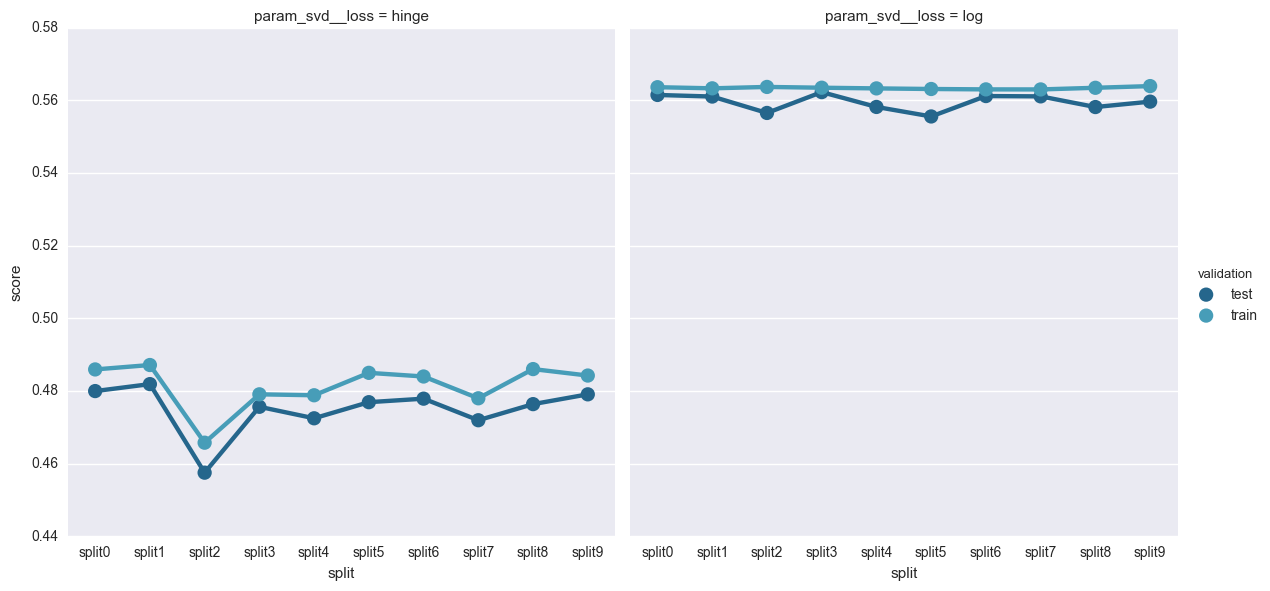

In [49]:
g = sns.factorplot(x="split", y="score", hue="validation",col="param_svd__loss", data=vis_df(svd_grid),
                   capsize=.2, palette="YlGnBu_d", size=6, aspect=1,ci=None)
g.despine(left=True)

In [40]:
pipeline_nb = Pipeline([
         ('NB', MultinomialNB())
])

parameters_nb = {'NB__alpha':(0.01,.1,1,10)}

In [41]:
nb_grid = gridSearch(pipeline_nb,parameters_nb,CV=10,score='f1_macro')

Performing grid search...
pipeline: ['NB']
parameters:
{'NB__alpha': (0.01, 0.1, 1, 10)}
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:   49.8s finished


done in 55.327s

Best score: 0.563
Best parameters set:
	NB__alpha: 1


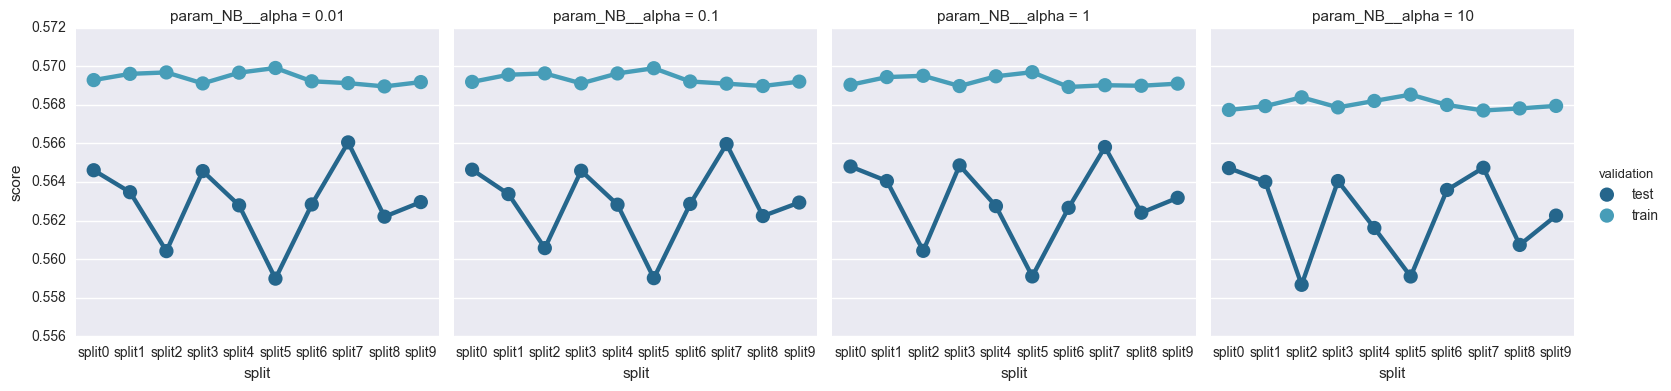

In [51]:
g = sns.factorplot(x="split", y="score", hue="validation", col="param_NB__alpha", data=vis_df(nb_grid),
                   capsize=.2, palette="YlGnBu_d", size=4, aspect=1,ci=None)
g.despine(left=True)

In [91]:
svd = SGDClassifier(warm_start = True,loss='log',penalty='l2')
svd.fit(X_train_hv,  y_train)
y_pred = svd.predict(X_test_hv)

In [92]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        1.0       0.65      0.77      0.71     43769
        2.0       0.53      0.45      0.49     42962
        3.0       0.53      0.49      0.51     43568
        4.0       0.51      0.45      0.48     43856
        5.0       0.63      0.73      0.68     43751

avg / total       0.57      0.58      0.57    217906



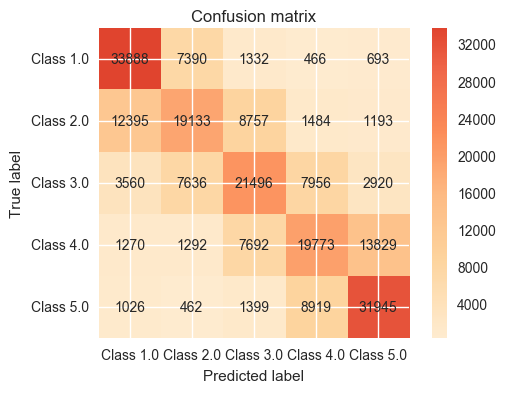

In [93]:
plot.confusion_matrix(y_test, y_pred)

## Finding Top words for each categories

###  20 Top Words for One Star reviews

In [95]:
feature_names = vectorizer.get_feature_names()
sorted(zip(svd.coef_[0], feature_names),reverse=True)[:20]

[(4.9605715105410191, 'worst'),
 (4.0903292648732794, 'horrible'),
 (3.4810555941550807, 'terrible'),
 (3.1851765430824397, 'never'),
 (2.8436483813347655, 'awful'),
 (2.7696448205424495, 'rude'),
 (2.6460729355537351, 'will never'),
 (2.5721658993260759, 'disgusting'),
 (2.4377423717941147, 'money'),
 (2.3922772800918635, 'even'),
 (2.3721579521526892, 'manager'),
 (2.2239876878447959, 'told'),
 (2.1736558142973244, 'one star'),
 (2.1244591986218406, 'gross'),
 (2.0737065559288963, 'ever'),
 (2.0605408585274056, 'waste'),
 (2.0546646484506028, 'cold'),
 (2.0337388853635012, 'bad'),
 (1.9709754100900778, 'sick'),
 (1.9379822028388873, 'left')]

###  20 Top Words for Two Star reviews

In [96]:
feature_names = vectorizer.get_feature_names()
sorted(zip(svd.coef_[1], feature_names),reverse=True)[:20]

[(3.6610398148853265, 'two star'),
 (2.8289507366828563, 'bland'),
 (2.7037472772012818, 'mediocre'),
 (2.4811791921751967, 'meh'),
 (2.2315572968631905, 'better'),
 (2.1528979328632465, 'disappointing'),
 (1.975702500710252, 'ok'),
 (1.9317016947484695, 'disappointed'),
 (1.9113709936729852, 'dry'),
 (1.8406991295954882, 'overpriced'),
 (1.6892089002190869, 'wasn'),
 (1.6452880447744913, 'unfortunately'),
 (1.6201047818729313, 'impressed'),
 (1.6169682659716491, 'average'),
 (1.5936806031916027, 'okay'),
 (1.4706511533973594, 'however'),
 (1.448419279256657, 'maybe'),
 (1.4348667139175764, 'much'),
 (1.3481759589567766, 'disappointment'),
 (1.3431862979068634, 'won')]

###  20 Top Words for Three Star reviews

In [97]:
feature_names = vectorizer.get_feature_names()
sorted(zip(svd.coef_[2], feature_names),reverse=True)[:20]

[(3.4369470364907944, 'decent'),
 (3.3338411100324641, 'ok'),
 (2.7453704204509153, 'good'),
 (2.534777218411183, 'however'),
 (2.4183512203400936, 'three star'),
 (2.4125368880598397, 'though'),
 (2.3802812069323882, 'bit'),
 (2.3695369058971627, 'okay'),
 (2.1814929582039584, 'star'),
 (2.1653095611863562, 'average'),
 (2.0621752572138385, 'pretty'),
 (1.9526015219399186, 'little'),
 (1.8345636875511482, 'probably'),
 (1.7040445273747264, 'alright'),
 (1.6648391019888169, 'food good'),
 (1.6253092603414079, 'wasn'),
 (1.6069362859671399, 'overall'),
 (1.6007702355698534, 'nothing'),
 (1.5388246333952762, 'pretty good'),
 (1.4047459261351367, 'solid')]

###  20 Top Words for Four Star reviews

In [98]:
feature_names = vectorizer.get_feature_names()
sorted(zip(svd.coef_[3], feature_names),reverse=True)[:20]

[(2.9109156929982714, 'good'),
 (2.5958852279756846, 'great'),
 (2.2796047475370904, 'delicious'),
 (2.0344098803474395, 'tasty'),
 (1.9709346402712389, 'enjoyed'),
 (1.8805008354418218, 'little'),
 (1.7040814419025825, 'definitely'),
 (1.5943356183231927, 'nice'),
 (1.5938126176988352, 'complaint'),
 (1.4303422029326458, 'excellent'),
 (1.4187138789308205, 'yummy'),
 (1.3528975804056316, 'really good'),
 (1.3525431135419279, 'fan'),
 (1.3445749523008321, 'bit'),
 (1.261785201275009, 'solid'),
 (1.1954849784846286, 'happy'),
 (1.1946920365194083, 'four star'),
 (1.1350135481694139, 'loved'),
 (1.1062616282006172, 'always'),
 (1.0871610860107381, 'yum')]

###  20 Top Words for Five Star reviews

In [101]:
feature_names = vectorizer.get_feature_names()
sorted(zip(svd.coef_[4], feature_names),reverse=True)[:20]

[(5.3960682373801312, 'amazing'),
 (5.0130666720473798, 'best'),
 (3.6643786805146719, 'delicious'),
 (3.5204038673521576, 'awesome'),
 (3.1921582294949311, 'favorite'),
 (3.0717434811055195, 'love'),
 (3.0433089682014316, 'great'),
 (3.0183470992401804, 'perfect'),
 (2.9154522642273091, 'excellent'),
 (2.8782455800991014, 'fantastic'),
 (2.484032827362598, 'wonderful'),
 (2.2885604212446542, 'everything'),
 (2.1682357563200774, 'every'),
 (2.102793008619416, 'incredible'),
 (1.9744704985191064, 'loved'),
 (1.9135250643468449, 'outstanding'),
 (1.8805561061708658, 'can wait'),
 (1.8624151768072663, 'vega'),
 (1.8362968511794002, 'friendly'),
 (1.8078630199483274, 'always')]